## Introduction

Quick data visualization and model training using Heart Disease Dataset https://www.kaggle.com/datasets/neurocipher/heartdisease/data .

Objective: create simple end-to-end scikit-learn pipelines to compare different classification models, using AUC and F1 metrics as scores.

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import BaseEstimator

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
import os
os.listdir('/content/drive/MyDrive/Datasets/heart_disease')
with open('/content/drive/MyDrive/Datasets/heart_disease/Heart_Disease_Prediction.csv', 'r') as f:
  df = pd.read_csv(f)

In [23]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


## EDA

In [24]:
df_eda = df.copy()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [25]:
df_eda['Heart Disease'] = df_eda['Heart Disease'].replace({'Presence': 1, 'Absence': 0})

/tmp/ipython-input-2181774237.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eda['Heart Disease'] = df_eda['Heart Disease'].replace({'Presence': 1, 'Absence': 0})


In [26]:
missing_values = df_eda.isnull().sum()
columns_with_nan = missing_values[missing_values > 0]

if not columns_with_nan.empty:
    print("Columns with NaN or null values:")
    print(columns_with_nan)

In [27]:
df_eda.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


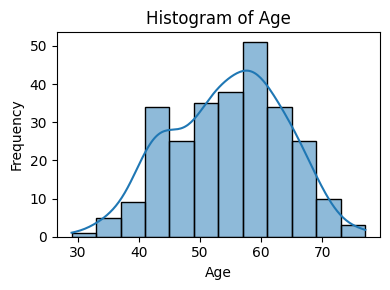

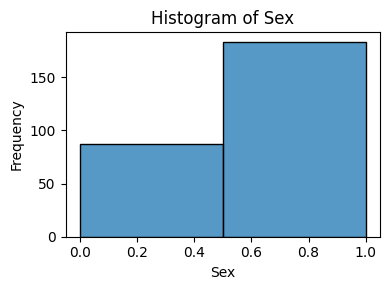

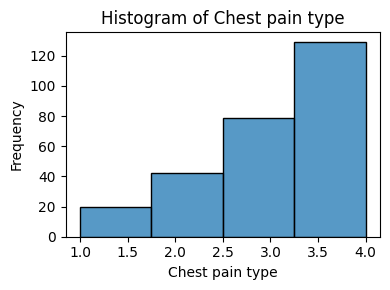

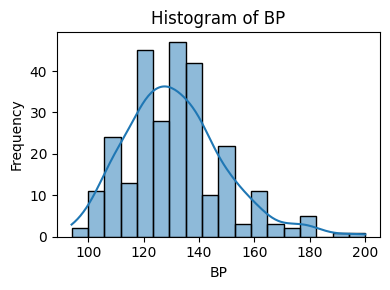

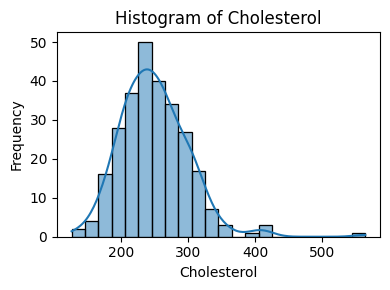

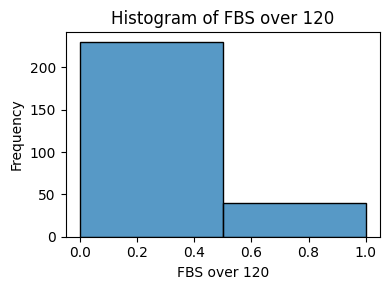

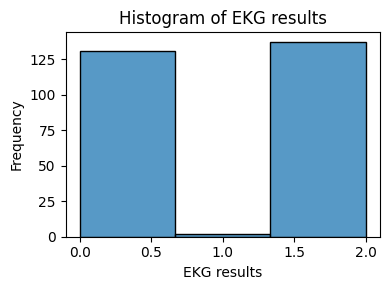

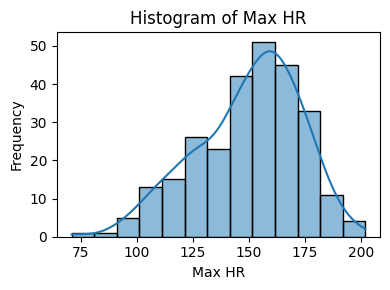

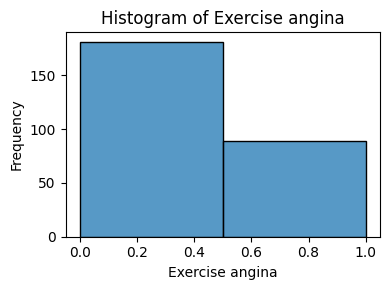

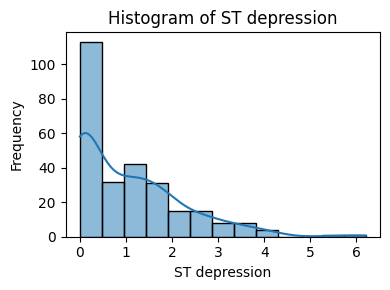

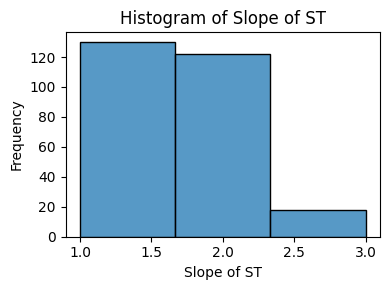

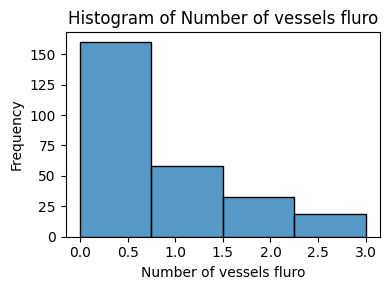

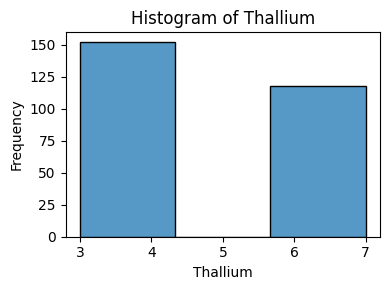

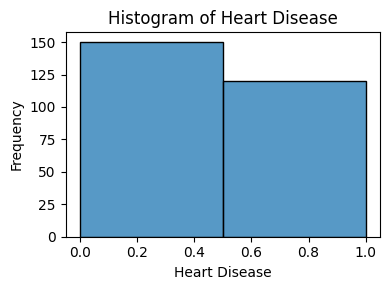

In [28]:
for column in df_eda.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(4, 3))

    if df_eda[column].dtype == 'int64' and df_eda[column].nunique() <= 15:
        # For integer columns with few unique values, set bins to the number of unique values
        num_bins = df_eda[column].nunique()
        sns.histplot(df_eda[column], kde=False, bins=num_bins) # kde might not be meaningful for few bins
    else:
        # For other numeric columns (floats or many unique integers), use 'auto' bins
        sns.histplot(df_eda[column], kde=True, bins='auto')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [29]:
df_eda['Heart Disease'].value_counts()

,count
Heart Disease,
0,150
1,120


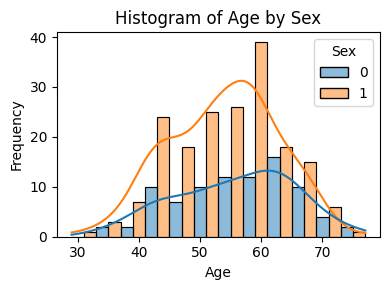

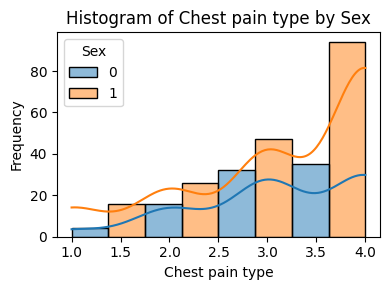

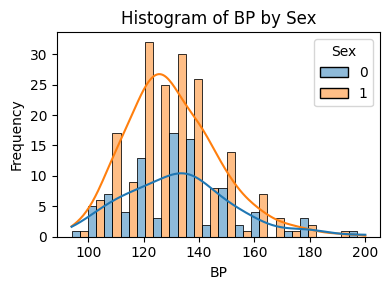

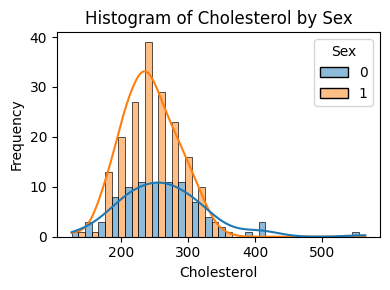

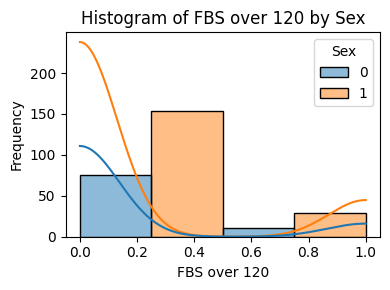

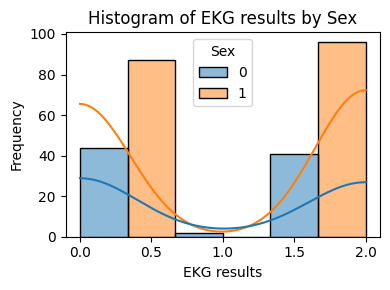

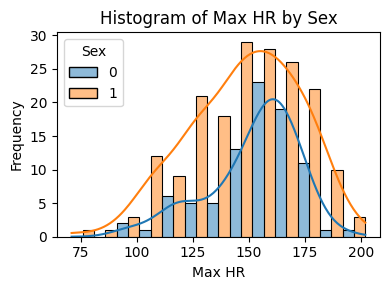

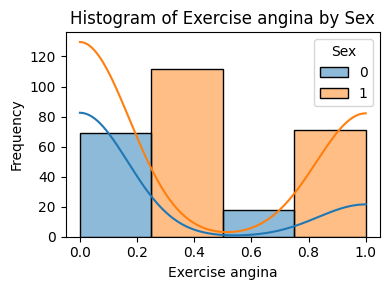

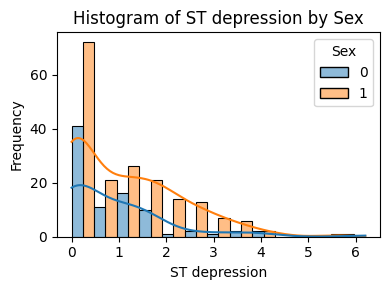

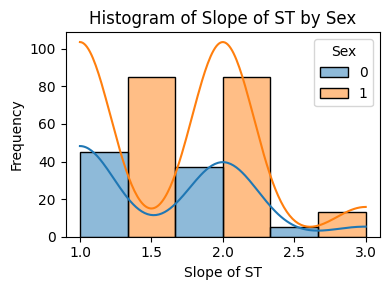

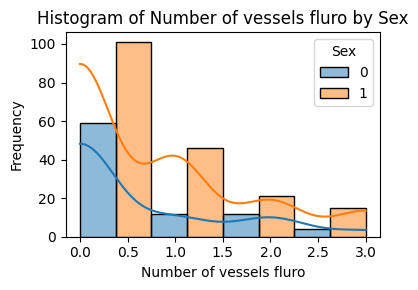

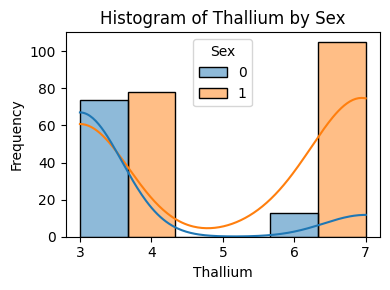

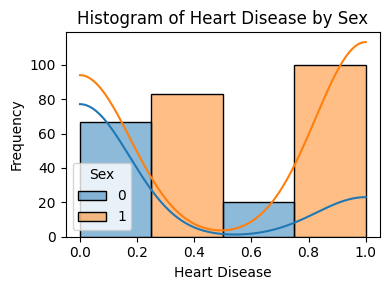

In [30]:
for column in df_eda.select_dtypes(include=['int64', 'float64']).columns:
    if column != 'Sex': # Exclude 'Sex' itself from being plotted against itself
        plt.figure(figsize=(4, 3))

        if df_eda[column].dtype == 'int64' and df_eda[column].nunique() <= 15:
            # For integer columns with few unique values, set bins to the number of unique values
            num_bins = df_eda[column].nunique()
            sns.histplot(data=df_eda, x=column, hue='Sex', kde=True, multiple='dodge', bins=num_bins) # kde might not be meaningful for few bins
        else:
            # For other numeric columns (floats or many unique integers), use 'auto' bins
            sns.histplot(data=df_eda, x=column, hue='Sex', kde=True, multiple='dodge', bins='auto')

        plt.title(f'Histogram of {column} by Sex')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

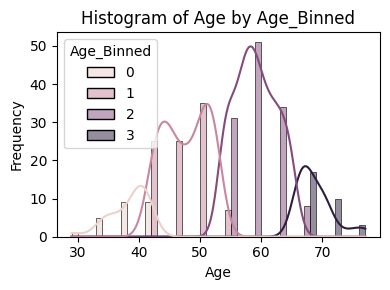

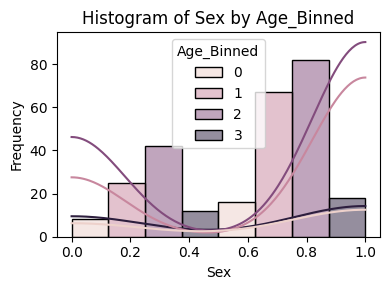

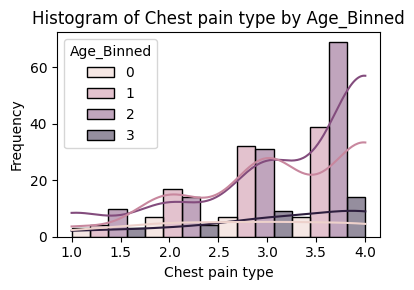

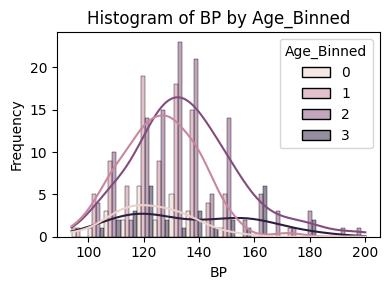

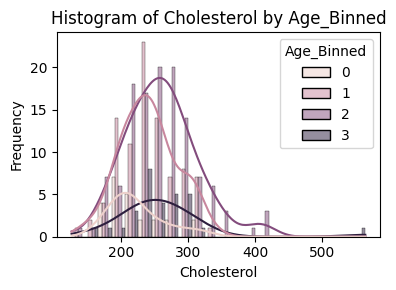

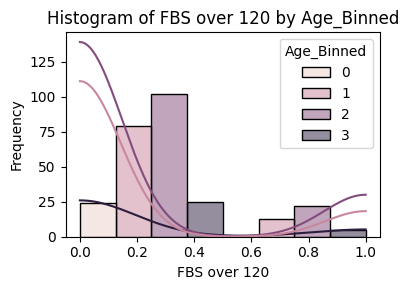

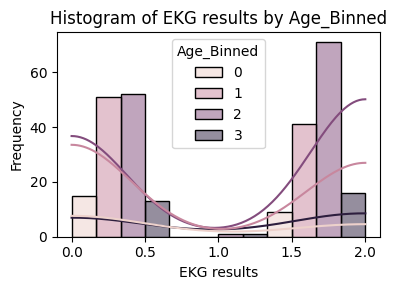

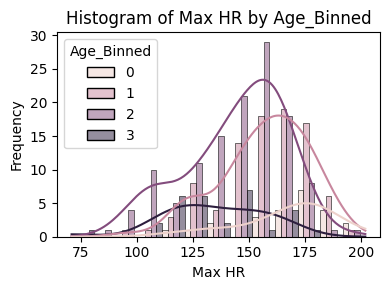

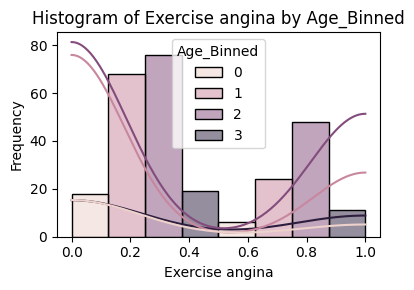

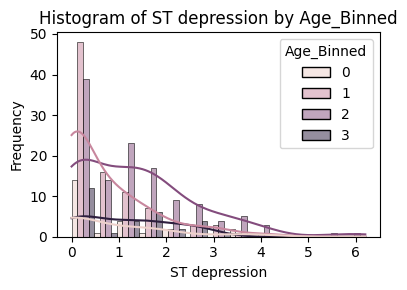

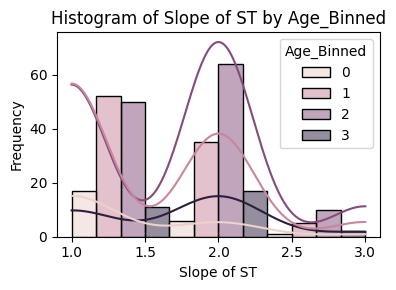

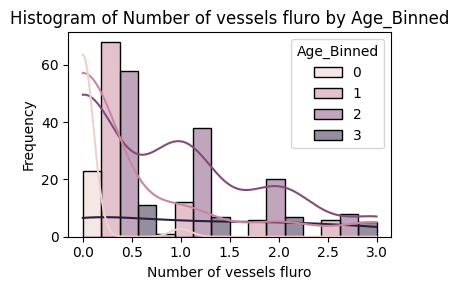

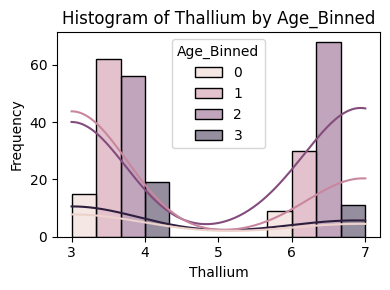

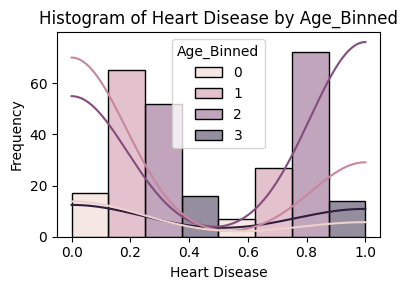

In [31]:
df_eda['Age_Binned'] = pd.cut(df_eda['Age'], bins=4, labels=False)
for column in df_eda.select_dtypes(include=['int64', 'float64']).columns:
    if column not in ['Age_Binned']: # Exclude 'Sex' itself from being plotted against itself
        plt.figure(figsize=(4, 3))

        if df_eda[column].dtype == 'int64' and df_eda[column].nunique() <= 15:
            # For integer columns with few unique values, set bins to the number of unique values
            num_bins = df_eda[column].nunique()
            sns.histplot(data=df_eda, x=column, hue='Age_Binned', kde=True, multiple='dodge', bins=num_bins) # kde might not be meaningful for few bins
        else:
            # For other numeric columns (floats or many unique integers), use 'auto' bins
            sns.histplot(data=df_eda, x=column, hue='Age_Binned', kde=True, multiple='dodge', bins='auto')

        plt.title(f'Histogram of {column} by Age_Binned')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

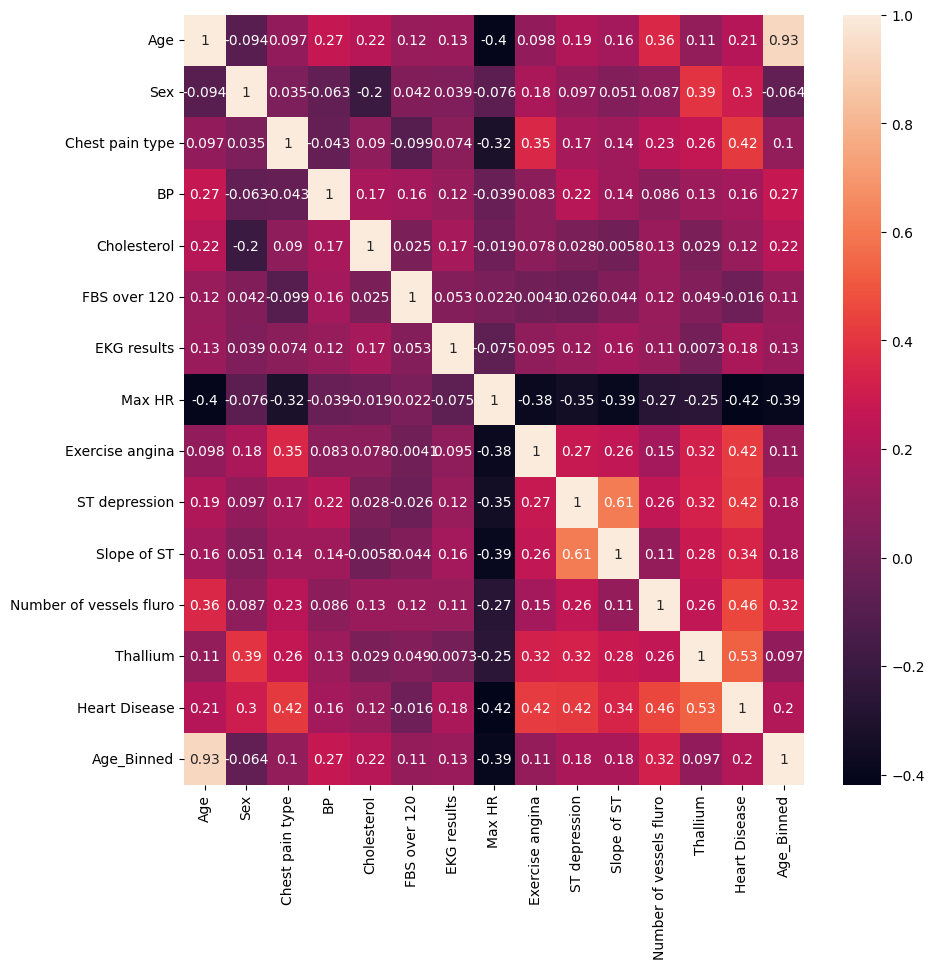

In [32]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_eda.corr(), annot=True)
plt.show()

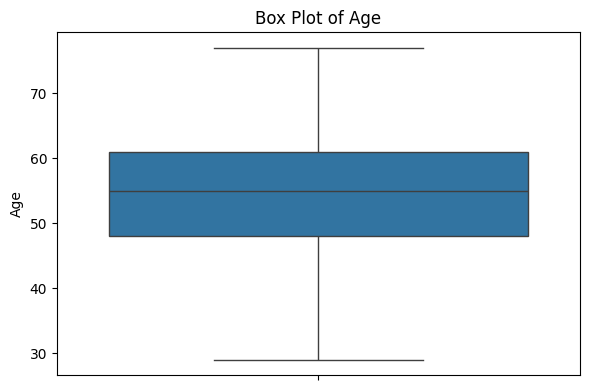

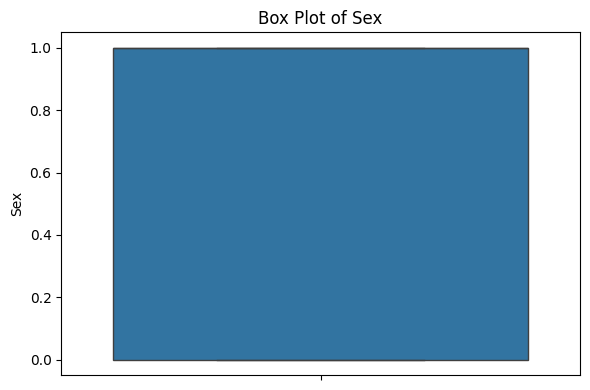

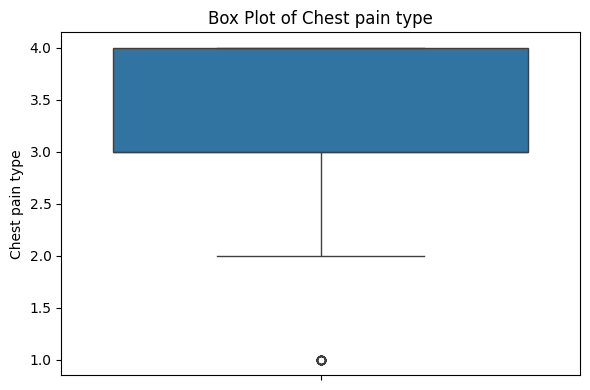

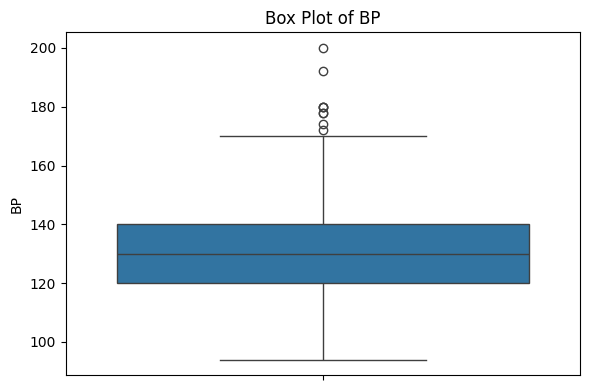

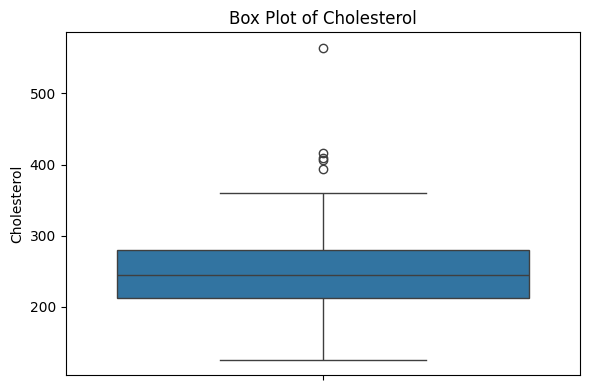

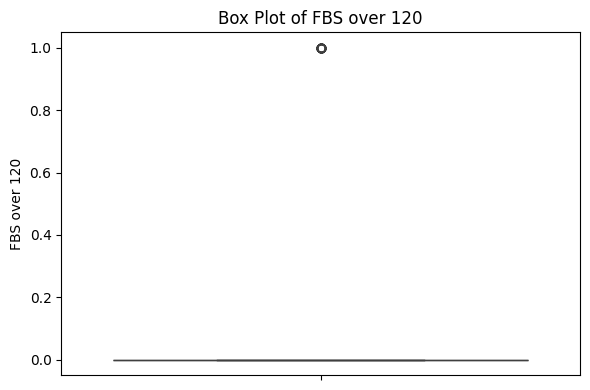

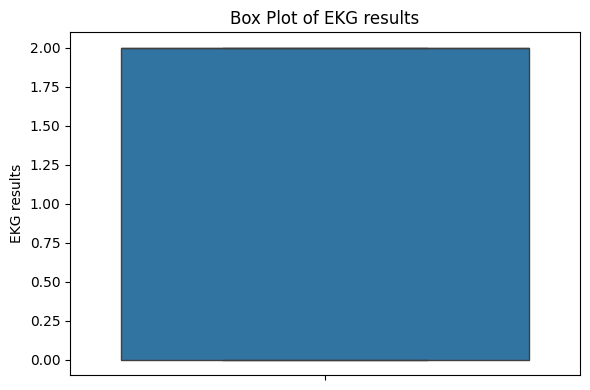

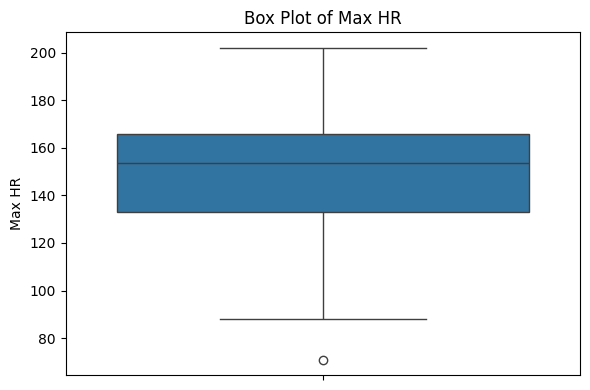

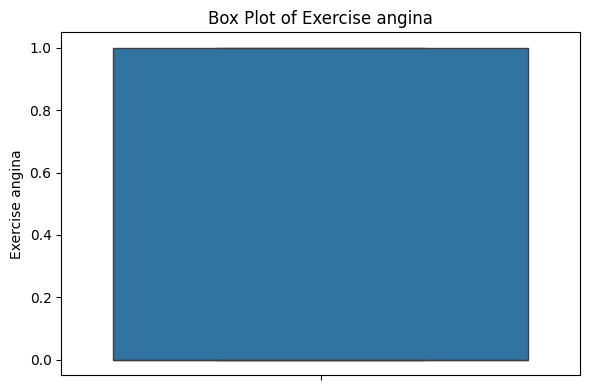

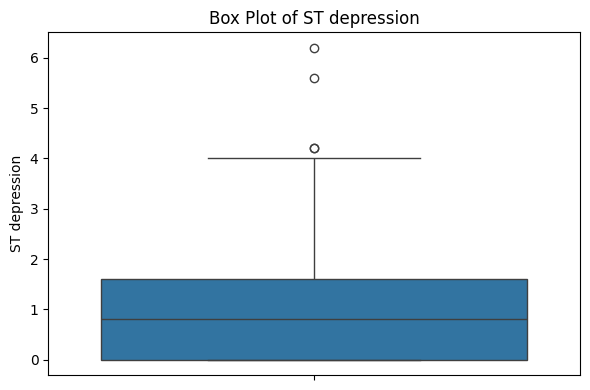

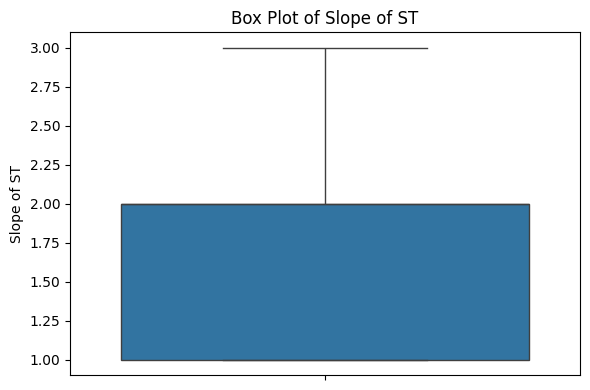

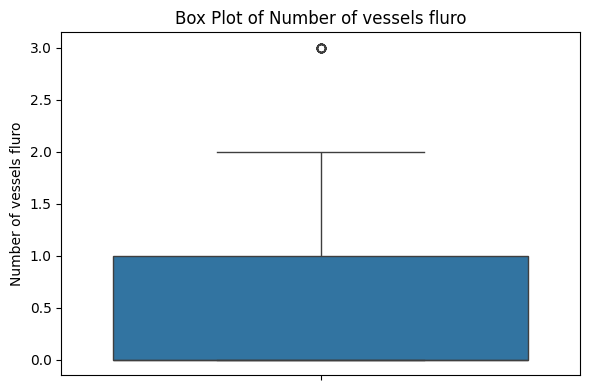

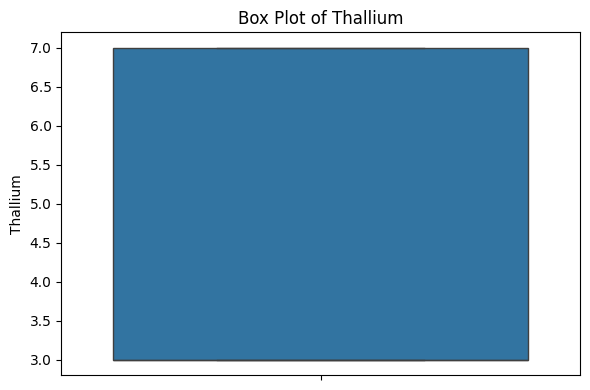

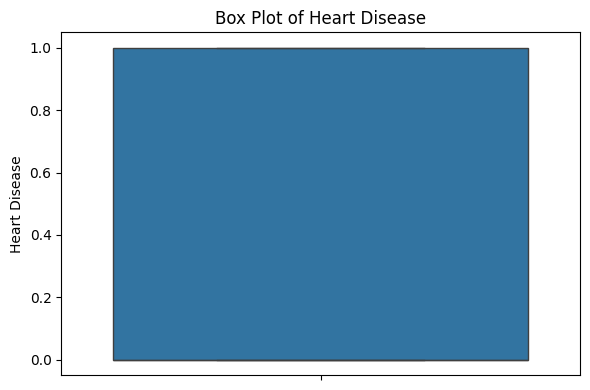

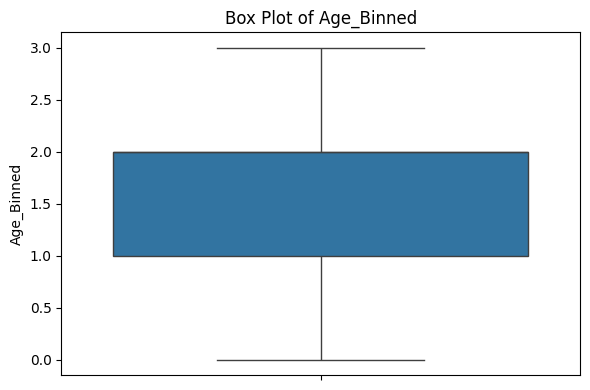

In [33]:
for column in df_eda.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_eda[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

# Data split

In [34]:
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
categorical_cols = ["Thallium", "Chest pain type", "EKG results", "Slope of ST", "Number of vessels fluro", "FBS over 120", "Sex", "Exercise angina"]

/tmp/ipython-input-1231703799.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})


# Logistic regression

In [35]:
preprocess_lr_1 = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols)
])

pipeline_lr_1 = Pipeline([
    ('preprocess', preprocess_lr_1),
    ('model', LogisticRegression())
])

parameters_lr_1 = [
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    },
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    },
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['elasticnet'],
        'model__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'model__solver': ['saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    }
]

scoring = {"F1": "f1", "AUC": "roc_auc"}

# Suppress ConvergenceWarning during GridSearchCV
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_lr_1 = GridSearchCV(pipeline_lr_1, parameters_lr_1, cv=cv, scoring=scoring, refit="AUC", verbose=1)
grid_lr_1.fit(X_train, y_train)

# Reset warnings to default after GridSearchCV
warnings.filterwarnings("default", category=ConvergenceWarning)

best_model_lr_1 = grid_lr_1.best_estimator_

print(f"Best Parameters: {grid_lr_1.best_params_}")
print(f"CV f1 mean (Best Model): {grid_lr_1.cv_results_['mean_test_F1'][grid_lr_1.best_index_]:.4f}")
print(f"CV f1 std (Best Model): {grid_lr_1.cv_results_['std_test_F1'][grid_lr_1.best_index_]:.4f}")
print(f"CV AUC mean (Best Model): {grid_lr_1.cv_results_['mean_test_AUC'][grid_lr_1.best_index_]:.4f}")
print(f"CV AUC std (Best Model): {grid_lr_1.cv_results_['std_test_AUC'][grid_lr_1.best_index_]:.4f}")

Fitting 10 folds for each of 546 candidates, totalling 5460 fits
Best Parameters: {'model__C': 0.01, 'model__class_weight': None, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}
CV f1 mean (Best Model): 0.5875
CV f1 std (Best Model): 0.1060
CV AUC mean (Best Model): 0.7810
CV AUC std (Best Model): 0.0930


In [36]:
preprocess_lr_2 = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

pipeline_lr_2 = Pipeline([
    ('preprocess', preprocess_lr_2),
    ('model', LogisticRegression())
])


parameters_lr_2 = [
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    },
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    },
    {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'model__penalty': ['elasticnet'],
        'model__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'model__solver': ['saga'],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300]
    }
]

scoring = {"F1": "f1", "AUC": "roc_auc"}

# Suppress ConvergenceWarning during GridSearchCV
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_lr_2 = GridSearchCV(pipeline_lr_2, parameters_lr_2, cv=cv, scoring=scoring, refit="AUC", verbose=1)
grid_lr_2.fit(X_train, y_train)

# Reset warnings to default after GridSearchCV
warnings.filterwarnings("default", category=ConvergenceWarning)

best_model_lr_2 = grid_lr_2.best_estimator_

print(f"Best Parameters: {grid_lr_2.best_params_}")
print(f"CV f1 mean (Best Model): {grid_lr_2.cv_results_['mean_test_F1'][grid_lr_2.best_index_]:.4f}")
print(f"CV f1 std (Best Model): {grid_lr_2.cv_results_['std_test_F1'][grid_lr_2.best_index_]:.4f}")
print(f"CV AUC mean (Best Model): {grid_lr_2.cv_results_['mean_test_AUC'][grid_lr_2.best_index_]:.4f}")
print(f"CV AUC std (Best Model): {grid_lr_2.cv_results_['std_test_AUC'][grid_lr_2.best_index_]:.4f}")

Fitting 10 folds for each of 546 candidates, totalling 5460 fits
Best Parameters: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
CV f1 mean (Best Model): 0.8152
CV f1 std (Best Model): 0.0910
CV AUC mean (Best Model): 0.9195
CV AUC std (Best Model): 0.0608


# SVM

In [37]:
preprocess_svm = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

pipeline_svm = Pipeline([
    ('preprocess', preprocess_svm),
    ('model', SVC())
])


parameters_svm = [
    {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree': [2,3,4],
        'model__gamma': ['scale', 'auto'],
        "model__coef0": [0, 0.2, 0.4],
        'model__class_weight': [None, 'balanced'],
        'model__max_iter': [100, 200, 300, -1]
    }
]

scoring = {"F1": "f1", "AUC": "roc_auc"}

# Suppress ConvergenceWarning during GridSearchCV
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=cv, scoring=scoring, refit="AUC", verbose=1)
grid_svm.fit(X_train, y_train)

# Reset warnings to default after GridSearchCV
warnings.filterwarnings("default", category=ConvergenceWarning)

best_model_svm = grid_svm.best_estimator_

print(f"Best Parameters: {grid_svm.best_params_}")
print(f"CV f1 mean (Best Model): {grid_svm.cv_results_['mean_test_F1'][grid_svm.best_index_]:.4f}")
print(f"CV f1 std (Best Model): {grid_svm.cv_results_['std_test_F1'][grid_svm.best_index_]:.4f}")
print(f"CV AUC mean (Best Model): {grid_svm.cv_results_['mean_test_AUC'][grid_svm.best_index_]:.4f}")
print(f"CV AUC std (Best Model): {grid_svm.cv_results_['std_test_AUC'][grid_svm.best_index_]:.4f}")

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits
Best Parameters: {'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 0, 'model__degree': 2, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__max_iter': 100}
CV f1 mean (Best Model): 0.8061
CV f1 std (Best Model): 0.0889
CV AUC mean (Best Model): 0.9198
CV AUC std (Best Model): 0.0591


# Random Forest

In [38]:
preprocess_rf = ColumnTransformer([
    # ('num', StandardScaler(), numerical_cols),
    # ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

pipeline_rf = Pipeline([
    # ('preprocess', preprocess_rf),
    ('model', RandomForestClassifier())
])


parameters_rf = [
    {
        'model__n_estimators': [100],
        'model__criterion': ['gini', 'entropy', "log_loss"],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 3],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2', None],
        'model__class_weight': [None, 'balanced']
    }
]

scoring = {"F1": "f1", "AUC": "roc_auc"}

# Suppress ConvergenceWarning during GridSearchCV
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_rf = GridSearchCV(pipeline_rf, parameters_rf, cv=cv, scoring=scoring, refit="AUC", verbose=1)
grid_rf.fit(X_train, y_train)

# Reset warnings to default after GridSearchCV
warnings.filterwarnings("default", category=ConvergenceWarning)

best_model_rf = grid_rf.best_estimator_

print(f"Best Parameters: {grid_rf.best_params_}")
print(f"CV f1 mean (Best Model): {grid_rf.cv_results_['mean_test_F1'][grid_rf.best_index_]:.4f}")
print(f"CV f1 std (Best Model): {grid_rf.cv_results_['std_test_F1'][grid_rf.best_index_]:.4f}")
print(f"CV AUC mean (Best Model): {grid_rf.cv_results_['mean_test_AUC'][grid_rf.best_index_]:.4f}")
print(f"CV AUC std (Best Model): {grid_rf.cv_results_['std_test_AUC'][grid_rf.best_index_]:.4f}")

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best Parameters: {'model__class_weight': None, 'model__criterion': 'log_loss', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
CV f1 mean (Best Model): 0.8175
CV f1 std (Best Model): 0.0857
CV AUC mean (Best Model): 0.9224
CV AUC std (Best Model): 0.0670


# Gradient Boosting

In [42]:
preprocess_gbm = ColumnTransformer([
    # ('num', StandardScaler(), numerical_cols),
    # ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

pipeline_gbm = Pipeline([
    # ('preprocess', preprocess_gbm),
    ('model', XGBClassifier())
])


parameters_gbm = [
    {
        'model__n_estimators': [100],
        'model__max_depth': [None, 3, 5, 10],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__min_child_weight': [1, 5, 10],
        'model__gamma': [0, 0.1, 1],
        'model__reg_lambda': [1, 5],
        'model__reg_alpha': [0, 0.1],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
    }
]

scoring = {"F1": "f1", "AUC": "roc_auc"}

# Suppress ConvergenceWarning during GridSearchCV
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_gbm = GridSearchCV(pipeline_gbm, parameters_gbm, cv=cv, scoring=scoring, refit="AUC", verbose=1)
grid_gbm.fit(X_train, y_train)

# Reset warnings to default after GridSearchCV
warnings.filterwarnings("default", category=ConvergenceWarning)

best_model_gbm = grid_gbm.best_estimator_

print(f"Best Parameters: {grid_gbm.best_params_}")
print(f"CV f1 mean (Best Model): {grid_gbm.cv_results_['mean_test_F1'][grid_gbm.best_index_]:.4f}")
print(f"CV f1 std (Best Model): {grid_gbm.cv_results_['std_test_F1'][grid_gbm.best_index_]:.4f}")
print(f"CV AUC mean (Best Model): {grid_gbm.cv_results_['mean_test_AUC'][grid_gbm.best_index_]:.4f}")
print(f"CV AUC std (Best Model): {grid_gbm.cv_results_['std_test_AUC'][grid_gbm.best_index_]:.4f}")

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
Best Parameters: {'model__colsample_bytree': 0.6, 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': None, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 1}
CV f1 mean (Best Model): 0.8058
CV f1 std (Best Model): 0.0905
CV AUC mean (Best Model): 0.9173
CV AUC std (Best Model): 0.0649


# Model selection

## Comparison

In [43]:
results = {}

# Logistic Regression results
results['LogReg'] = {
    'AUC mean': grid_lr_2.cv_results_['mean_test_AUC'][grid_lr_2.best_index_],
    'AUC std': grid_lr_2.cv_results_['std_test_AUC'][grid_lr_2.best_index_],
    'F1 mean': grid_lr_2.cv_results_['mean_test_F1'][grid_lr_2.best_index_],
    'F1 std': grid_lr_2.cv_results_['std_test_F1'][grid_lr_2.best_index_]
}

# SVM results
results['SVM'] = {
    'AUC mean': grid_svm.cv_results_['mean_test_AUC'][grid_svm.best_index_],
    'AUC std': grid_svm.cv_results_['std_test_AUC'][grid_svm.best_index_],
    'F1 mean': grid_svm.cv_results_['mean_test_F1'][grid_svm.best_index_],
    'F1 std': grid_svm.cv_results_['std_test_F1'][grid_svm.best_index_]
}

# Random Forest results
results['RandomForest'] = {
    'AUC mean': grid_rf.cv_results_['mean_test_AUC'][grid_rf.best_index_],
    'AUC std': grid_rf.cv_results_['std_test_AUC'][grid_rf.best_index_],
    'F1 mean': grid_rf.cv_results_['mean_test_F1'][grid_rf.best_index_],
    'F1 std': grid_rf.cv_results_['std_test_F1'][grid_rf.best_index_]
}

# Gradient Boosting results
results['XGBoost'] = {
    'AUC mean': grid_gbm.cv_results_['mean_test_AUC'][grid_gbm.best_index_],
    'AUC std': grid_gbm.cv_results_['std_test_AUC'][grid_gbm.best_index_],
    'F1 mean': grid_gbm.cv_results_['mean_test_F1'][grid_gbm.best_index_],
    'F1 std': grid_gbm.cv_results_['std_test_F1'][grid_gbm.best_index_]
}

comparison_df = pd.DataFrame.from_dict(results, orient='index')
print(comparison_df.round(4))


              AUC mean  AUC std  F1 mean  F1 std
LogReg          0.9195   0.0608   0.8152  0.0910
SVM             0.9198   0.0591   0.8061  0.0889
RandomForest    0.9224   0.0670   0.8175  0.0857
XGBoost         0.9173   0.0649   0.8058  0.0905


O SVM é o modelo escolhido pois todos os modelos tiveram AUC semelhantes, mas o SVM tem o menor desvio padrão de AUC entre os folds. O mesmo ocorre com o F1, os modelos apresentam F1 muito semelhantes, mas é o menor desvio padrão de F1 entre os folds.

In [51]:
best_model = best_model_svm
best_model_pipeline = pipeline_svm

# Model Analisys

In [46]:
y_oof = cross_val_predict(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv,
    method="predict"
)

# y_oof = cross_val_predict(
#     estimator=best_model,
#     X=X_train,
#     y=y_train,
#     cv=cv,
#     method="predict_proba"
# )[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

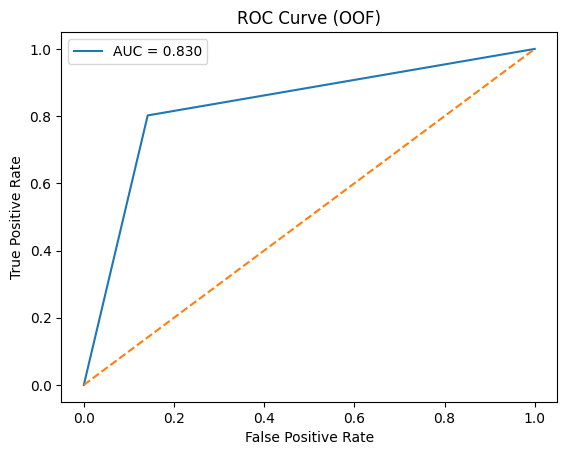

In [47]:
fpr, tpr, _ = roc_curve(y_train, y_oof)
auc = roc_auc_score(y_train, y_oof)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()
plt.show()

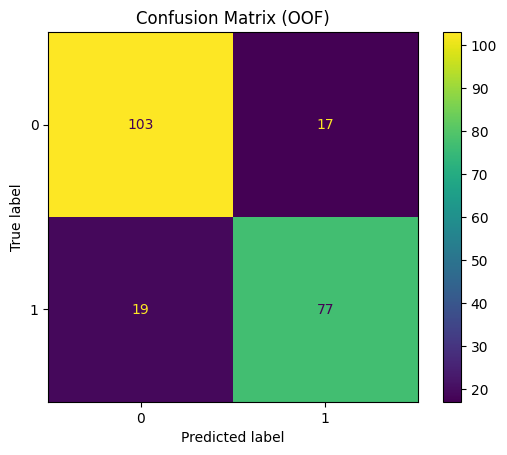

In [48]:
threshold = 0.5
y_pred_oof = (y_oof >= threshold).astype(int)

cm = confusion_matrix(y_train, y_pred_oof)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix (OOF)")
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       120
           1       0.82      0.80      0.81        96

    accuracy                           0.83       216
   macro avg       0.83      0.83      0.83       216
weighted avg       0.83      0.83      0.83       216



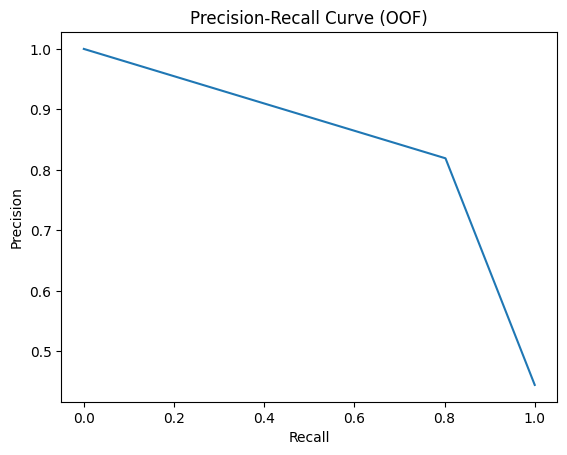

In [49]:
print(classification_report(y_train, y_pred_oof))

precision, recall, _ = precision_recall_curve(y_train, y_oof)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OOF)")
plt.show()

## Test

In [56]:
# y_test_proba = best_model.predict_proba("X_test")[:, 1]
# y_test_pred = (y_test_proba >= threshold).astype(int)

y_test_pred = best_model.predict(X_test_)
y_test_proba = y_test_pred

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



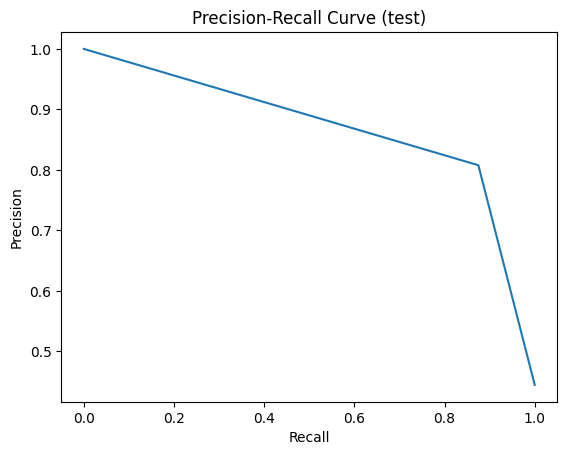

In [57]:
print(classification_report(y_test_, y_test_pred))

precision, recall, _ = precision_recall_curve(y_test_, y_test_pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (test)")
plt.show()

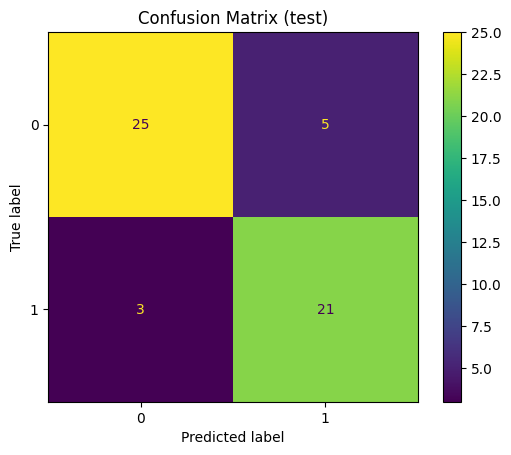

In [58]:
cm = confusion_matrix(y_test_, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix (test)")
plt.show()

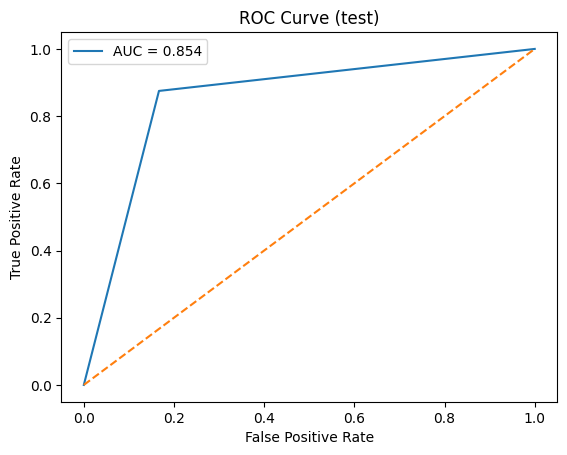

In [59]:
fpr, tpr, _ = roc_curve(y_test_, y_test_proba)
auc = roc_auc_score(y_test_, y_test_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (test)")
plt.legend()
plt.show()